## Setup

In [ ]:
!pip install -qq transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 86.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 93.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 21.9 MB/s eta 0:00:00


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Thu Jan 19 13:28:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    42W / 400W |      3MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [203]:
%cd "/content/drive/MyDrive/Colab Notebooks/BA"

/content/drive/MyDrive/Colab Notebooks/BA


In [204]:
%pwd

'/content/drive/MyDrive/Colab Notebooks/BA'

## Global Settings

In [ ]:
MAX_LEN = 400
BATCH_SIZE = 32

## Import and Clean Data

In [ ]:
# Import CSV
file_path = '/content/drive/MyDrive/Colab Notebooks/BA/data'
df = pd.read_parquet(file_path+"/reviews.parquet")

# Clean Data
df['clean_review'] = df.reviews.str.replace('✅ Trip Verified | ','', regex=False).str.strip()

### Extract Locations

In [ ]:
df['destination'] = None
df['departure'] = None


# Only assign to rows with routes
df.loc[~ df.route.isnull(), 'destination'] = df.loc[~ df.route.isnull(), 'route'].map(lambda x : x.split("to")[-1].split("via")[0].strip())
df.loc[~ df.route.isnull(), 'departure'] = df.loc[~ df.route.isnull(), 'route'].map(lambda x: x.split("to")[0].strip())

## Analyse Token Length

Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


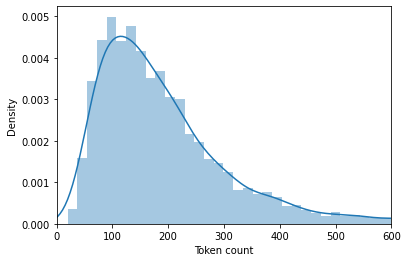

In [ ]:
token_lens = []

# can add a max len argument here but can also use for the encode argument. eg:
# tokenizer = AutoTokenizer.from_pretrained(checkpoint, max_len = 1000)
checkpoint = "cardiffnlp/twitter-roberta-base-sentiment"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

for txt in df.clean_review:
  tokens = tokenizer.encode(txt, max_length=1000)
  token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 600]);
plt.xlabel('Token count');

## Torch Dataloader

### Create Dataset Class

In [ ]:
class BAReviewDataset(Dataset):

    def __init__(self, reviews, tokenizer, max_len):
        self.reviews = reviews
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
)

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'index': item
            }

### Create Dataloader

Create a Torch dataset ds from the above class and use that to make a dataloader

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = BAReviewDataset(
    reviews=df.clean_review.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

## Putting it all together

### Run Analysis

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
checkpoint = "cardiffnlp/twitter-roberta-base-sentiment"

# Create Model and Tokenizer from checkpoint
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Create the dataloader from the df and tokenizer
data_loader = create_data_loader(df, tokenizer, MAX_LEN, BATCH_SIZE)

# Move model to gpu
model = model.to(device)

# Add a col to the df to store the negative scores
for k,v in model.config.id2label.items():
    df[v] = 0

print(f"Models loaded and moved to {device}")

# Put the model in eval mode
model = model.eval()
# Disable gradients since we are doing inference not training
with torch.no_grad():
    for data in tqdm(data_loader):
        input_ids = data["input_ids"].to(device)
        attention_mask = data["attention_mask"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        
        probs = F.softmax(outputs.logits, dim=1)

        for k,v in model.config.id2label.items():
            df.loc[data['index'], v] = probs[:,k].cpu().numpy()

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

Models loaded and moved to cuda:0


  0%|          | 0/109 [00:00<?, ?it/s]

### Rename Cols

**Labels**

0 -> Negative 

1 -> Neutral 

2 -> Positive



In [ ]:
df.rename(columns={"LABEL_0": "negative", "LABEL_1": "neutral", "LABEL_2":"positive"}, inplace=True)
df.columns

Index(['reviews', 'overall_rating', 'aircraft', 'type_of_traveller',
       'seat_type', 'route', 'date_flown', 'seat_comfort',
       'cabin_staff_service', 'food_&_beverages', 'inflight_entertainment',
       'ground_service', 'wifi_&_connectivity', 'value_for_money',
       'recommended', 'clean_review', 'destination', 'departure', 'negative',
       'neutral', 'positive'],
      dtype='object')

In [ ]:
df.overall_rating = df.overall_rating.astype('float')

### Assign Sentiment

Give each review the argmax.

In [ ]:
df["sentiment"] = df[["positive","negative","neutral"]].idxmax(axis=1)

### Analysis

In [ ]:
df['sentiment'].value_counts(normalize=True) * 100

negative    54.973973
positive    35.251591
neutral      9.774436
Name: sentiment, dtype: float64

Negative sentiment dominates all ratings up to 6.0

In [187]:
crosstab_df = pd.crosstab(index=df.overall_rating, columns = df.sentiment, normalize="index")
crosstab_df

sentiment,negative,neutral,positive
overall_rating,,,
1.0,0.954847,0.041169,0.003984
2.0,0.899743,0.089974,0.010283
3.0,0.869452,0.096606,0.033943
4.0,0.798319,0.130252,0.071429
5.0,0.656388,0.180617,0.162996
6.0,0.385027,0.288770,0.326203
7.0,0.175325,0.175325,0.649351
8.0,0.056338,0.092958,0.850704
9.0,0.026936,0.047138,0.925926


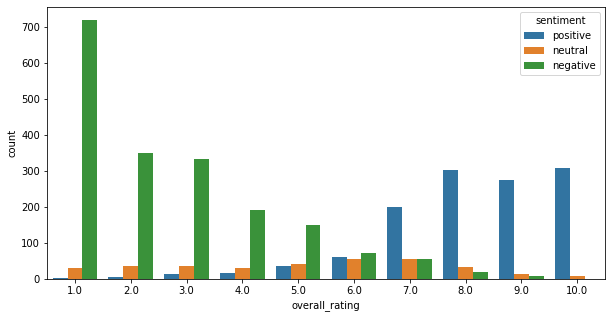

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(data=df, x="overall_rating", hue="sentiment")

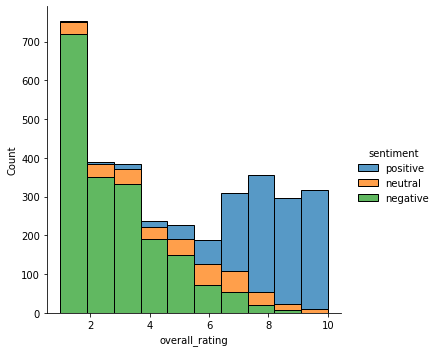

In [ ]:
sns.displot(df, x='overall_rating', hue='sentiment', multiple='stack', bins=10)
#plt.legend(title='Sentiment', loc='upper right', labels=['Negative', 'Positive'])

### Emotion Analysis

In [ ]:
checkpoint = "j-hartmann/emotion-english-distilroberta-base"
# Create Model and Tokenizer from checkpoint
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Create the dataloader from the df and tokenizer
data_loader = create_data_loader(df, tokenizer, MAX_LEN, BATCH_SIZE)

# Move model to gpu
model = model.to(device)

# Add a col to the df to store the negative scores
for k,v in model.config.id2label.items():
    df[v] = 0

print(f"Models loaded and moved to {device}")

# Put the model in eval mode
model = model.eval()
# Disable gradients since we are doing inference not training
with torch.no_grad():
    for data in tqdm(data_loader):
        input_ids = data["input_ids"].to(device)
        attention_mask = data["attention_mask"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        
        probs = F.softmax(outputs.logits, dim=1)

        for k,v in model.config.id2label.items():
            df.loc[data['index'], v+"_emo"] = probs[:,k].cpu().numpy()

Downloading:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/294 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

### Analysis

In [ ]:
emotions = [v+"_emo" for k,v in model.config.id2label.items()]
df["emotion"] = df[emotions].idxmax(axis=1)

In [ ]:
df['emotion'].value_counts(normalize=True) * 100

neutral_emo     30.161943
disgust_emo     19.144014
sadness_emo     15.587045
joy_emo         13.851938
surprise_emo     9.890110
fear_emo         6.969346
anger_emo        4.395604
Name: emotion, dtype: float64

Ratings 7+ see an increasing proportion of joy

Ratings 1-7 see a decreasing proportion of disgust

Neutral proportion peaks at ratings 6-7

Sadness greatest for ratings 1-2

Text(0, 0.5, 'Proportion of reviews')

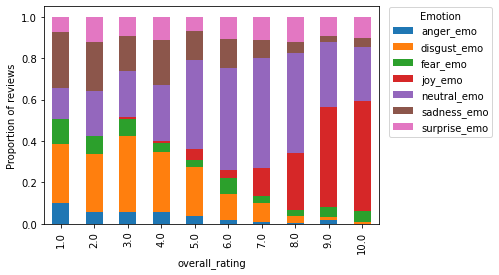

In [189]:
crosstab_df = pd.crosstab(index=df.overall_rating, columns = df.emotion, normalize="index")
crosstab_df.plot(kind="bar", stacked = True)
plt.legend(title='Emotion', loc=(1.03,0.4))
plt.ylabel('Proportion of reviews')

Text(13.481562499999995, 0.5, 'Number of Reviews')

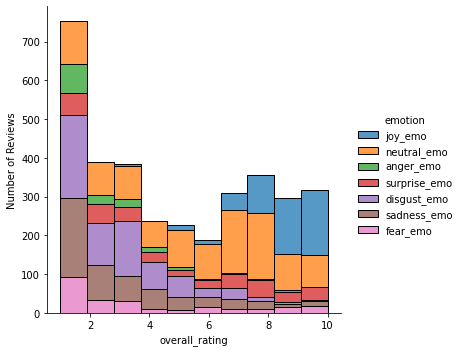

In [ ]:
sns.displot(df, x='overall_rating', hue='emotion', multiple='stack', bins=10)
#plt.legend(title='Sentiment', loc='upper right', labels=['Negative', 'Positive'])
plt.ylabel('Number of Reviews')

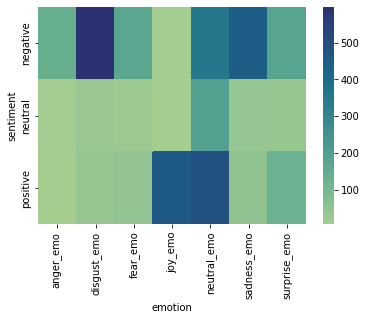

In [ ]:
sns.heatmap(pd.crosstab(index=df.sentiment, columns = df.emotion), cmap="crest")

### Poor review with positive sentiment

In [ ]:
df.query('overall_rating == 1').sort_values('positive', ascending=False)[['clean_review',"positive"]].values[0]

array(["I used British Airways Club Europe from LGW to Naples. Basically the flight is the same as long haul economy except no entertainment and the middle seat is left empty? As far as I can tell there is no difference in legroom and seats are identical to economy. I'm not sure how British Airways can pass this off as Business class.  My advice if booking a business class flight in Europe, look at competitors otherwise book economy and save the money. Only really good thing about flight was an amazing cabin staff that looked after us really well.",
       0.8079943060874939], dtype=object)

In [ ]:
df.sort_values('positive', ascending=False)['positive']

269     0.992884
719     0.991656
262     0.991497
659     0.991487
421     0.991126
          ...   
805     0.002757
680     0.002702
2697    0.002633
1168    0.002489
360     0.002153
Name: positive, Length: 3458, dtype: float64

### Old Analysis

In [ ]:
df['overall'] = df['overall_rating'].map(lambda x : 'positive' if x > 5 else 'neutral' if x == 5 else 'negative')

In [ ]:
df.groupby("overall")[top_emo].mean()

,disgust_emo,sadness_emo,joy_emo,surprise_emo,fear_emo,anger_emo
overall,,,,,,
negative,0.275789,0.215107,0.011897,0.118070,0.098139,0.092888
neutral,0.214906,0.160619,0.065934,0.106136,0.050892,0.053344
positive,0.056252,0.082485,0.301686,0.133119,0.046006,0.017272


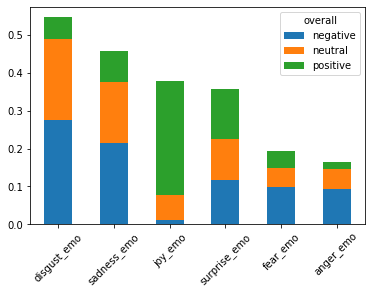

In [ ]:
df.groupby("overall")[top_emo].mean().transpose().plot.bar(stacked=True, rot=45)
plt.ylabel('Average Price')

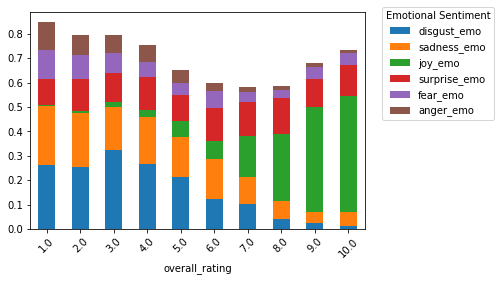

In [ ]:
df.groupby("overall_rating")[top_emo].mean().plot.bar(stacked=True, rot=45)
plt.legend(title='Emotional Sentiment', loc=(1.05,0.5))

In [ ]:
df[df.overall=='positive'][emotions].mean().sort_values(ascending=False)[0:4]

neutral_emo     0.363180
joy_emo         0.301686
surprise_emo    0.133119
sadness_emo     0.082485
dtype: float32

In [ ]:
df[df.overall=='neutral'][emotions].mean().sort_values(ascending=False)[0:4]

neutral_emo     0.348170
disgust_emo     0.214906
sadness_emo     0.160619
surprise_emo    0.106136
dtype: float32

In [ ]:
df[df.overall=='negative'][emotions].mean().sort_values(ascending=False)[0:4]

disgust_emo     0.275789
sadness_emo     0.215107
neutral_emo     0.188109
surprise_emo    0.118070
dtype: float32

### WordCloud

In [ ]:
from nltk.corpus import stopwords
import nltk 
nltk.download('stopwords')
from collections import Counter
# Import the stop word list
from nltk.tokenize import wordpunct_tokenize

def top_words(test, NUM_WORDS=25):
    NUM_WORDS = 25

    words = text.split()

    word_counts = Counter(word for word in words
                        if word not in set(stopwords.words('english') + ["flight", "BA", "airline", "aircraft", "plane"]))

    print(f'\nThe {NUM_WORDS} most frequent words are:\n')
    for i, (word, count) in enumerate(word_counts.most_common(NUM_WORDS)):
        print('%2s. %4s %s' % (i, count, word))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
text = " ".join(review for review in df.clean_review)
top_words(text)


The 25 most frequent words are:

 0. 2996 I
 1. 1246 The
 2.  487 service
 3.  467 London
 4.  418 seat
 5.  410 crew
 6.  382 food
 7.  381 British
 8.  374 would
 9.  362 -
10.  356 one
11.  342 cabin
12.  332 get
13.  328 time
14.  322 staff
15.  316 seats
16.  309 good
17.  304 We
18.  299 business
19.  276 flight.
20.  275 class
21.  269 Airways
22.  263 us
23.  240 could
24.  239 hours


In [ ]:
text = " ".join(review for review in df[df.overall=='positive'].clean_review)
top_words(text)


The 25 most frequent words are:

 0.  826 I
 1.  543 The
 2.  219 good
 3.  216 crew
 4.  183 food
 5.  178 service
 6.  173 cabin
 7.  161 London
 8.  144 time
 9.  132 seat
10.  115 -
11.  114 British
12.  107 seats
13.  106 flight.
14.  104 would
15.  102 Heathrow
16.   98 staff
17.   97 Club
18.   95 one
19.   93 really
20.   85 well
21.   82 first
22.   80 great
23.   79 new
24.   78 drinks


In [ ]:
text = " ".join(review for review in df[df.overall=='negative'].clean_review)
top_words(text)


The 25 most frequent words are:

 0. 2000 I
 1.  594 The
 2.  283 service
 3.  281 London
 4.  255 British
 5.  251 seat
 6.  251 get
 7.  247 would
 8.  240 one
 9.  219 We
10.  212 staff
11.  207 us
12.  204 business
13.  204 -
14.  195 told
15.  194 hours
16.  193 Airways
17.  180 seats
18.  179 customer
19.  176 class
20.  172 could
21.  172 food
22.  164 time
23.  162 crew
24.  160 They


In [ ]:
def getFrequencyDictForText(sentence):
    fullTermsDict = multidict.MultiDict()
    tmpDict = {}

    # making dict for counting frequencies
    for text in sentence.split(" "):
        if re.match("a|the|an|the|to|in|for|of|or|by|with|is|on|that|be", text):
            continue
            
        val = tmpDict.get(text, 0)
        tmpDict[text.lower()] = val + 1
    for key in tmpDict:
        fullTermsDict.add(key, tmpDict[key])
    return fullTermsDict

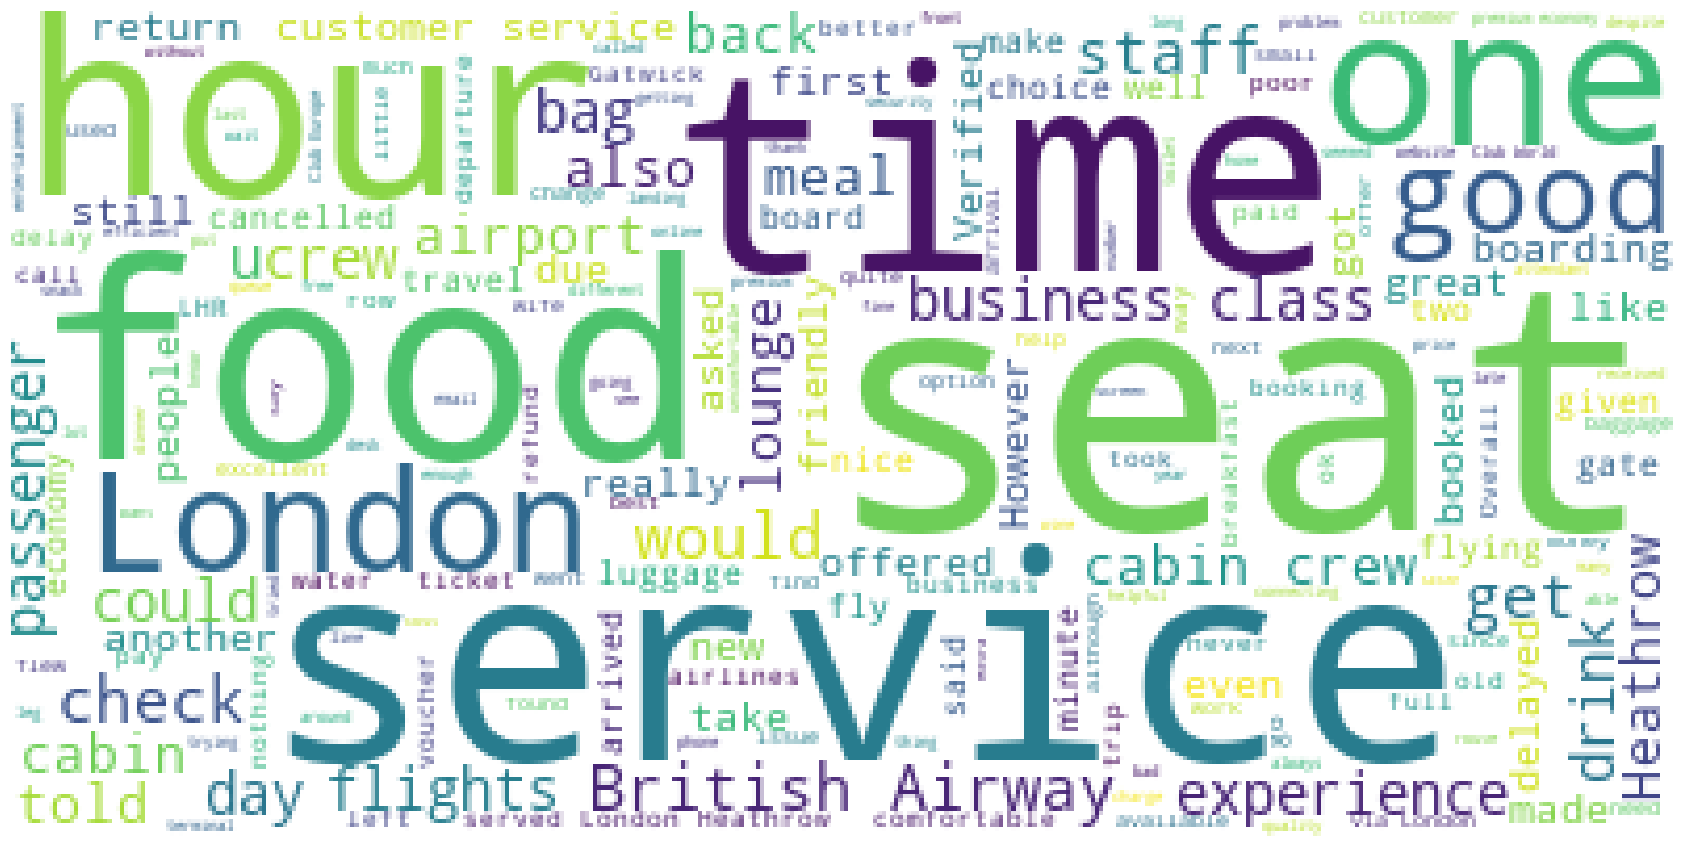

In [ ]:
text = " ".join(review for review in df.clean_review)

# Create stopword list:
ba_stopwords = set(stopwords.words('english') + ["flight", "BA", "airline", "aircraft", "plane"])
ba_stopwords.update(["flight", "BA", "airline", "aircraft", "plane"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=ba_stopwords, background_color="white").generate(text)

# Display the generated image:
fig, ax = plt.subplots(figsize=(30,30))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

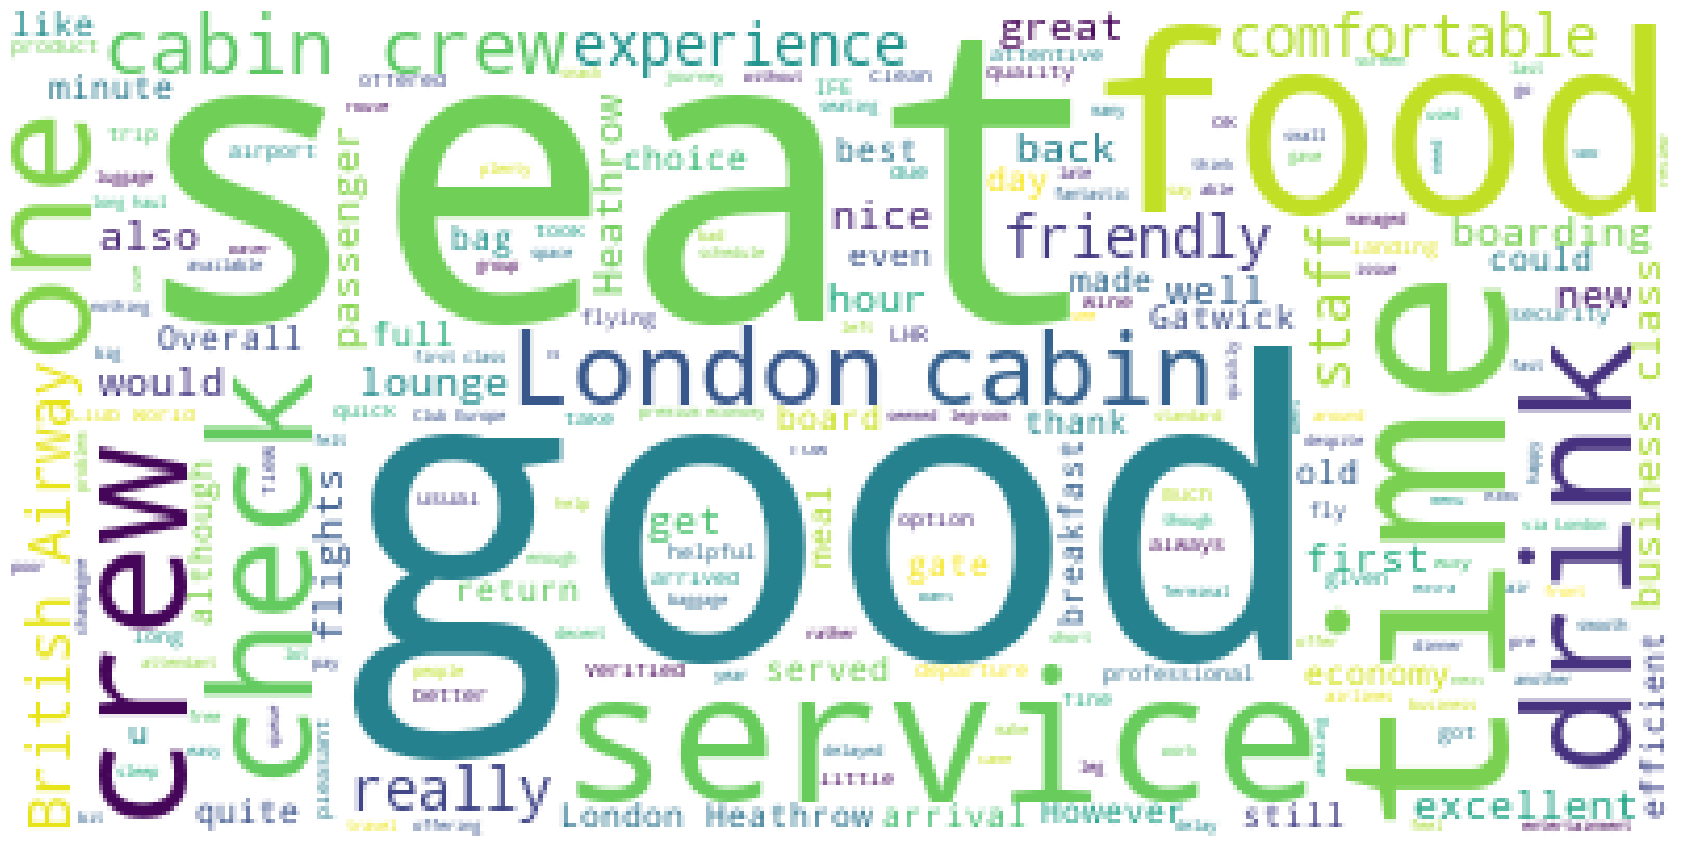

In [ ]:
text = " ".join(review for review in df[df.overall=='positive'].clean_review)

# Create stopword list:
#ba_stopwords = set(STOPWORDS)
ba_stopwords = set(stopwords.words('english') + ["flight", "BA", "airline", "aircraft", "plane"])
ba_stopwords.update(["flight", "BA", "airline", "aircraft", "plane"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=ba_stopwords, background_color="white").generate(text)

# Display the generated image:
fig, ax = plt.subplots(figsize=(30,30))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

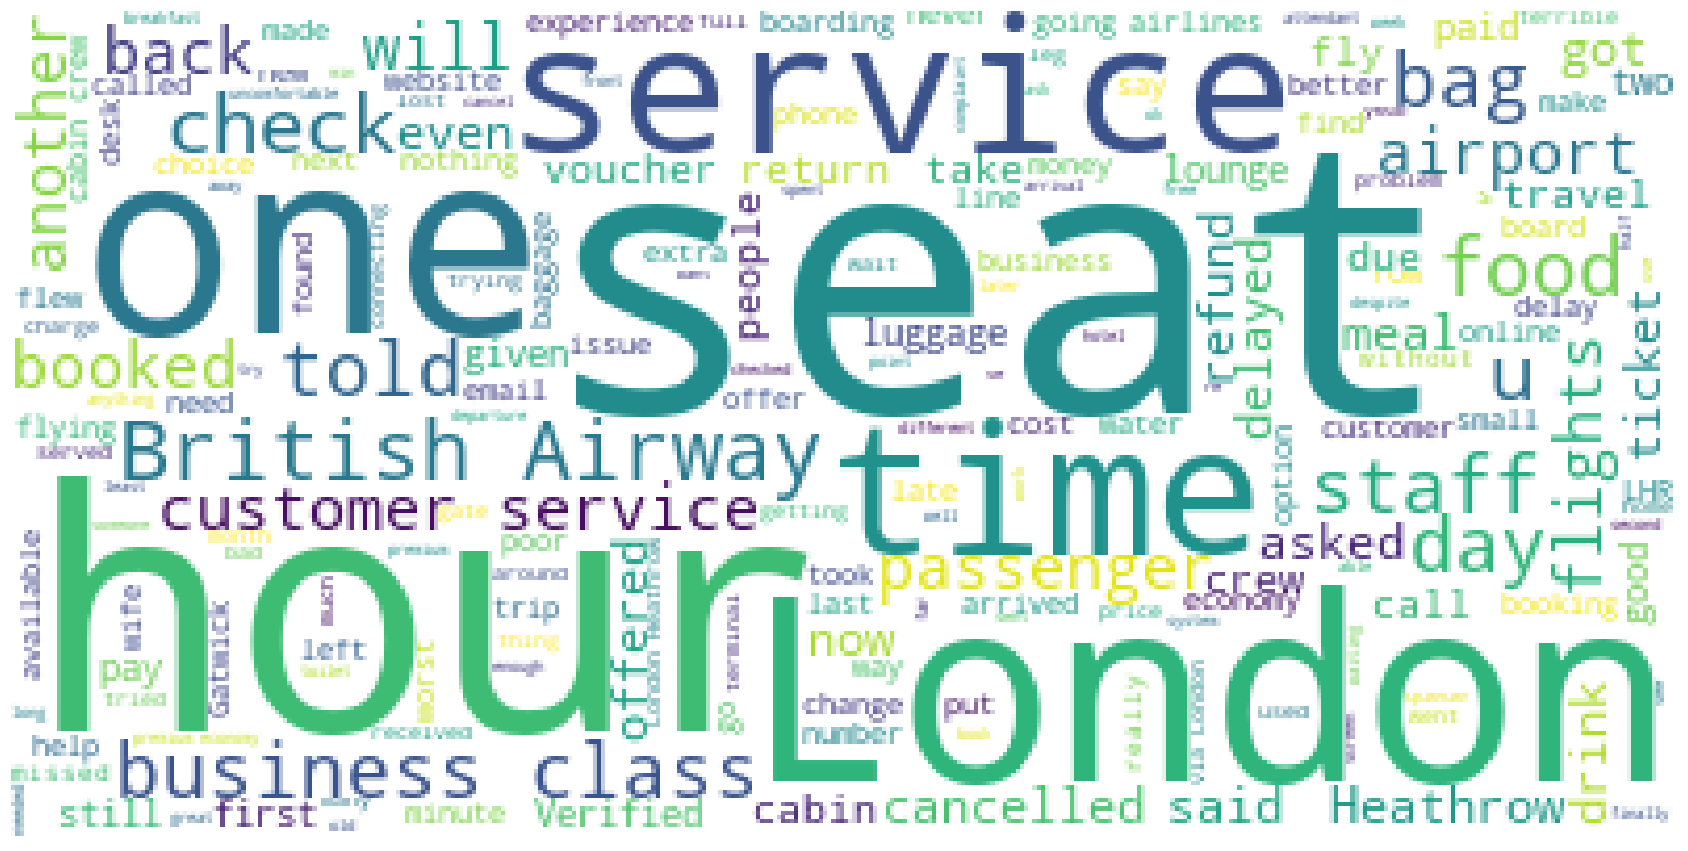

In [ ]:
text = " ".join(review for review in df[df.overall=='negative'].clean_review)

# Create stopword list:
ba_stopwords = set(STOPWORDS)
ba_stopwords.update(["flight", "BA", "airline", "aircraft", "plane"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=ba_stopwords, background_color="white").generate(text)

# Display the generated image:
fig, ax = plt.subplots(figsize=(30,30))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
x = set([2])
x.update([1])
print(x)
del x

{1, 2}


In [ ]:
df.columns

Index(['index', 'reviews', 'overall_rating', 'aircraft', 'type_of_traveller',
       'seat_type', 'route', 'date_flown', 'seat_comfort',
       'cabin_staff_service', 'food_&_beverages', 'inflight_entertainment',
       'ground_service', 'value_for_money', 'recommended',
       'wifi_&_connectivity', 'clean_review', 'destination', 'departure',
       'negative_score', 'admiration', 'amusement', 'anger', 'annoyance',
       'approval', 'caring', 'confusion', 'curiosity', 'desire',
       'disappointment', 'disapproval', 'disgust', 'embarrassment',
       'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love',
       'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse',
       'sadness', 'surprise', 'neutral', 'overall'],
      dtype='object')